In [1]:
library(ggplot2)

ibmdata = read.table("IBMdaily.txt",header=T)
ibm.date = as.Date(as.character(ibmdata$Date), format="%m/%d/%Y")
ibmdata$Date = ibm.date
attach(ibmdata)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

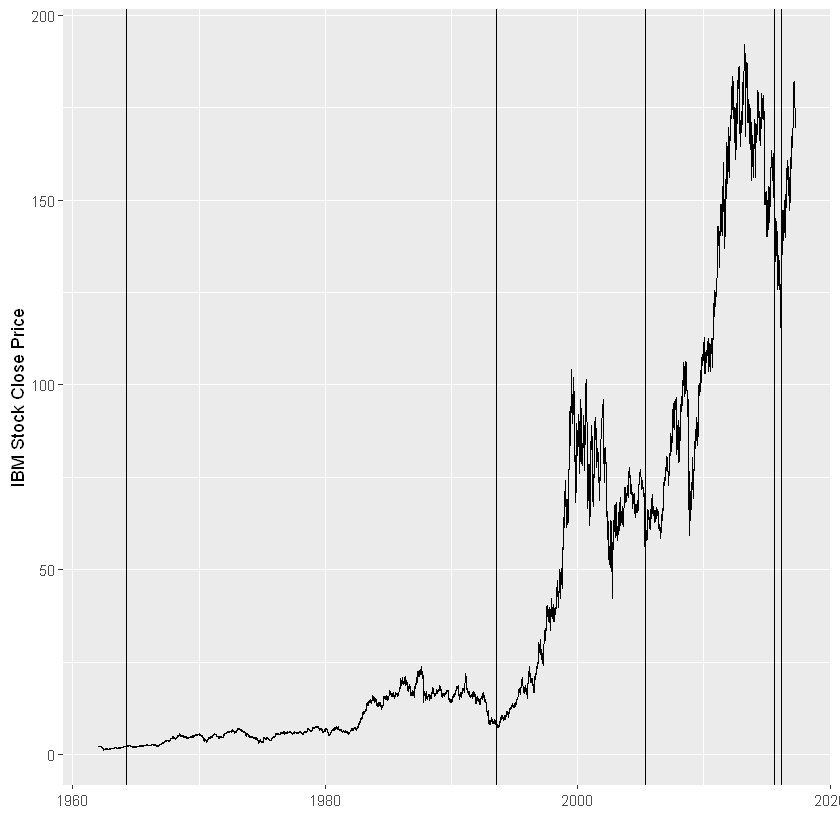

In [2]:
## Dates: April 7 1964, 27 July 1993, May 1 2005, Aug 5 2015, Feb 18 2016
ficom = which(Date=="1964-04-07")
loss = which(Date=="1993-07-27")
lenovo = which(Date=="2005-05-02")
healthm = which(Date=="2015-08-05")
truven = which(Date=="2016-02-18")
alldates = c(ficom,loss,lenovo,healthm,truven)

ggplot(ibmdata, aes(Date, AdjClose)) + geom_line() + xlab("") + ylab("IBM Stock Close Price")+
geom_vline(xintercept = as.numeric(Date[alldates]))

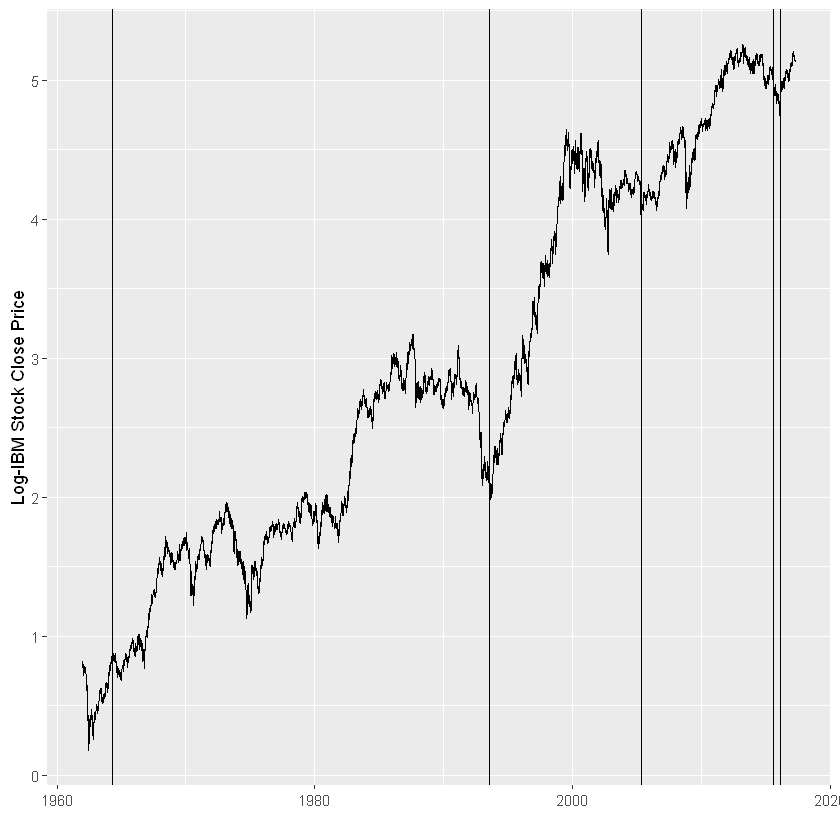

In [3]:
## IBM Stock Price: Non-constant variance => Transform
AdjClose.tr = log(AdjClose)
ggplot(ibmdata, aes(Date, AdjClose.tr)) + geom_line() + xlab("") + ylab("Log-IBM Stock Close Price")+
geom_vline(xintercept = as.numeric(Date[alldates]))

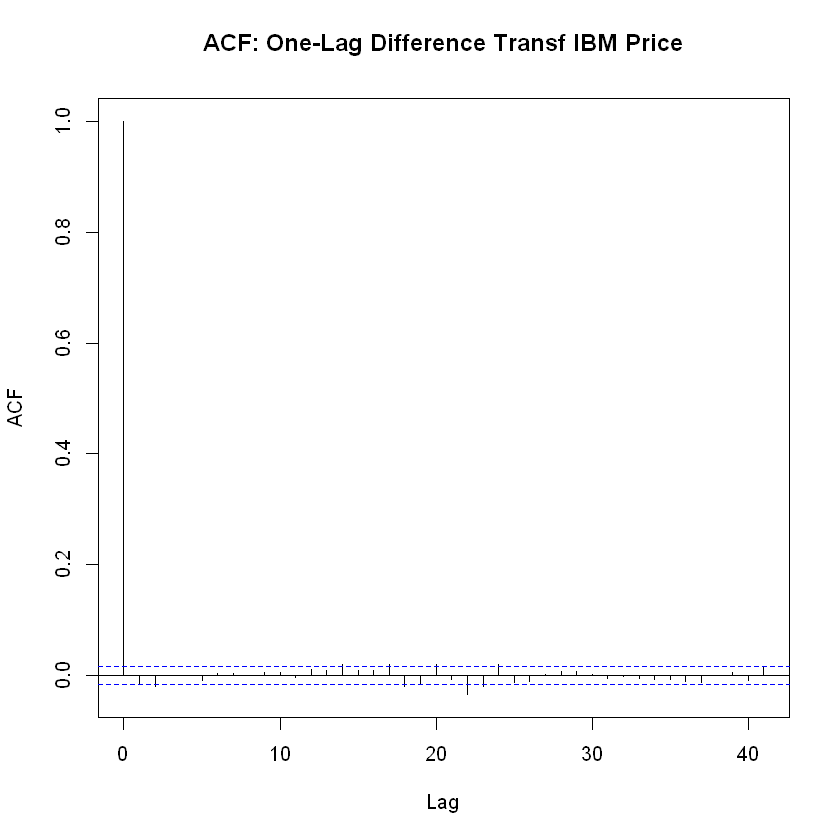

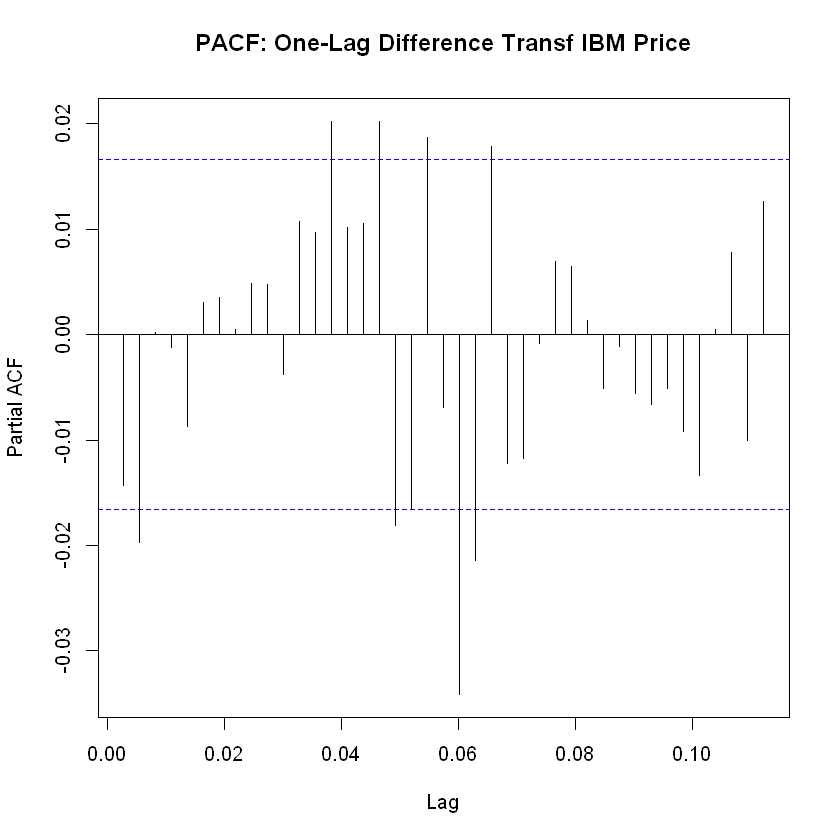

In [4]:
ts.price = ts(rev(AdjClose.tr),start=c(1962,1,2),frequency=365.25)
## Differencing to Remove Trend
diff.ts.price = diff(ts.price)
acf(as.vector(diff.ts.price),main="ACF: One-Lag Difference Transf IBM Price")
pacf(diff.ts.price,main="PACF: One-Lag Difference Transf IBM Price")

We observe ACF and regard the log difference series to be stationary due to fast decay. We can apply ARMA on it.

[1] 2
[1] 0


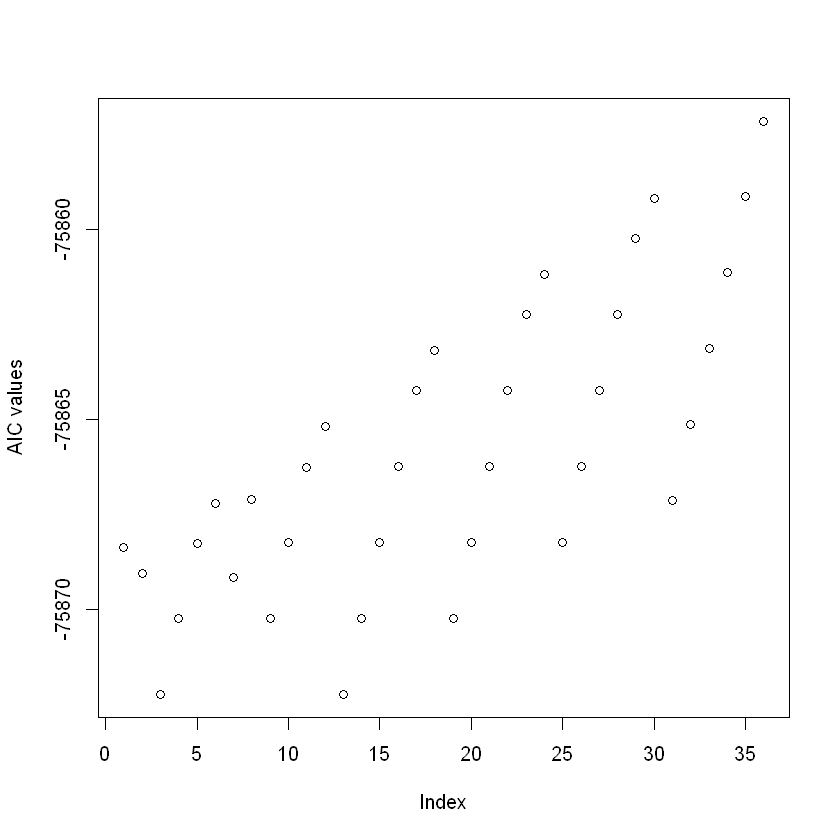

In [5]:
## Apply ARIMA

## Order selection -- AIC 
n = length(ts.price)
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)
for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(ts.price,order = c(p[i],1,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
}

aicv = as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1

print(porder)
print(qorder)

final_model = arima(ts.price, order = c(porder,1,qorder), method = "ML")

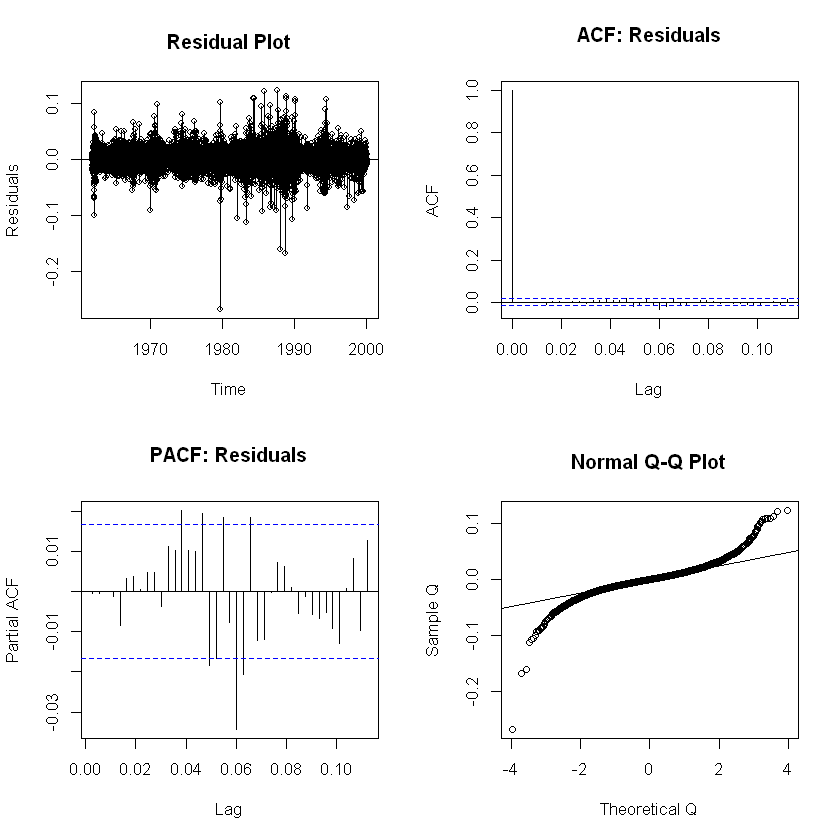

In [7]:
## GOF: residual analysis
par(mfrow=c(2,2))
plot(resid(final_model), ylab='Residuals',type='o',main="Residual Plot")
abline(h=0)
acf(resid(final_model),main="ACF: Residuals")
pacf(resid(final_model),main="PACF: Residuals")
qqnorm(resid(final_model),ylab="Sample Q",xlab="Theoretical Q")
qqline(resid(final_model))

Can treat as close to white noise...

In [8]:
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))


	Box-Pierce test

data:  final_model$resid
X-squared = 0.0047056, df = 1, p-value = 0.9453



	Box-Ljung test

data:  final_model$resid
X-squared = 0.0047068, df = 1, p-value = 0.9453


## FORECAST

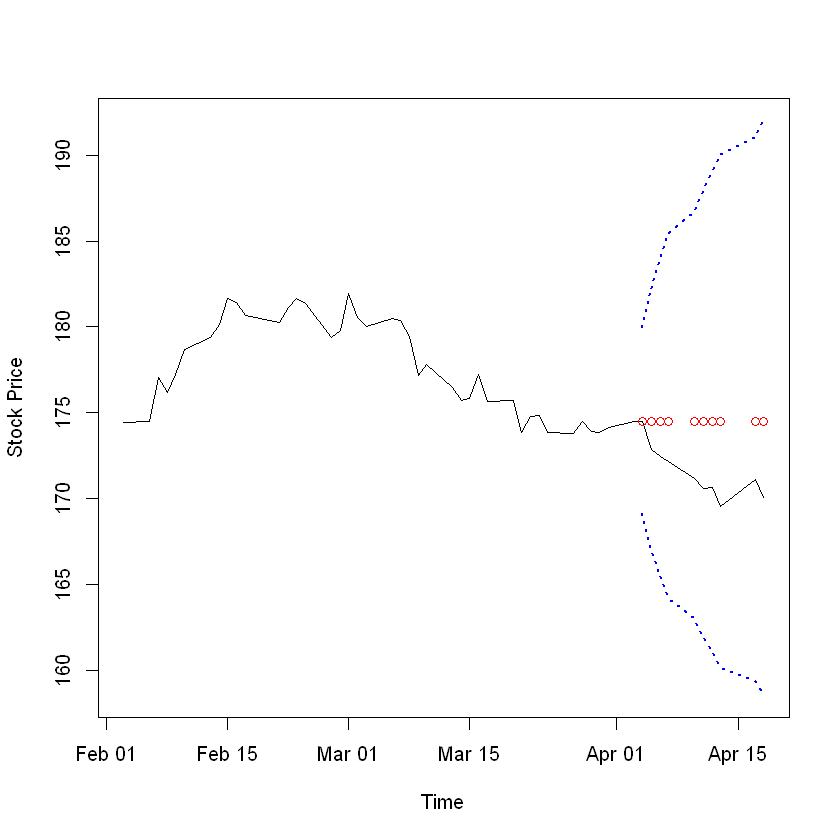

In [9]:
## Forecasting with ARIMA 
## 10 Days Ahead: 
n = length(ts.price)
nfit = n-10
outprice = arima(ts.price[1:nfit], order = c(porder,1,qorder),method = "ML")
outpred = predict(outprice,n.ahead=10)
ubound = outpred$pred+1.96*outpred$se
lbound = outpred$pred-1.96*outpred$se
ymin = min(exp(lbound))
ymax = max(exp(ubound))
plot(rev(ibm.date)[(n-50):n],exp(ts.price[(n-50):n]),type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Stock Price")
points(rev(ibm.date)[(nfit+1):n],exp(outpred$pred),col="red")
lines(rev(ibm.date)[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines(rev(ibm.date)[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")

Note the confidence band grows larger as time passes as uncertainity grows.

In [10]:
## Compute Accuracy Measures
obsprice = exp(ts.price[(nfit+1):n]) 
predprice = exp(outpred$pred)
### Mean Squared Prediction Error (MSPE)
mean((predprice-obsprice)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(predprice-obsprice))
### Mean Absolute Percentage Error (MAPE)
mean(abs(predprice-obsprice)/obsprice)
### Precision Measure (PM)
sum((predprice-obsprice)^2)/sum((obsprice-mean(obsprice))^2)

[1] 10.84517

[1] 2.978775

[1] 0.01743639

[1] 5.389947

In [11]:
### Does the observed data fall outside the prediction intervals?
sum(obsprice<exp(lbound))+sum(obsprice>exp(ubound))

[1] 0

In [12]:
## Daily Prediction over a period of 10 days in a rolling manner ie predict only 1 day ahead taking previous prediction
## as additional observed value in time series. 
outpred.10 = NULL
ubound.10 = NULL
lbound.10 = NULL
n = length(ts.price)
for(i in 1:10){
   nfit = n-(10-i-1)
   outprice = arima(ts.price[1:nfit], order = c(porder,1,qorder),method = "ML")
   pred.1 = predict(outprice,n.ahead=1)
   outpred.10 = c(outpred.10,pred.1$pred)
   ubound.10 = c(ubound.10, pred.1$pred+1.96*pred.1$se)
   lbound.10 = c(lbound.10, pred.1$pred-1.96*pred.1$se)
  }

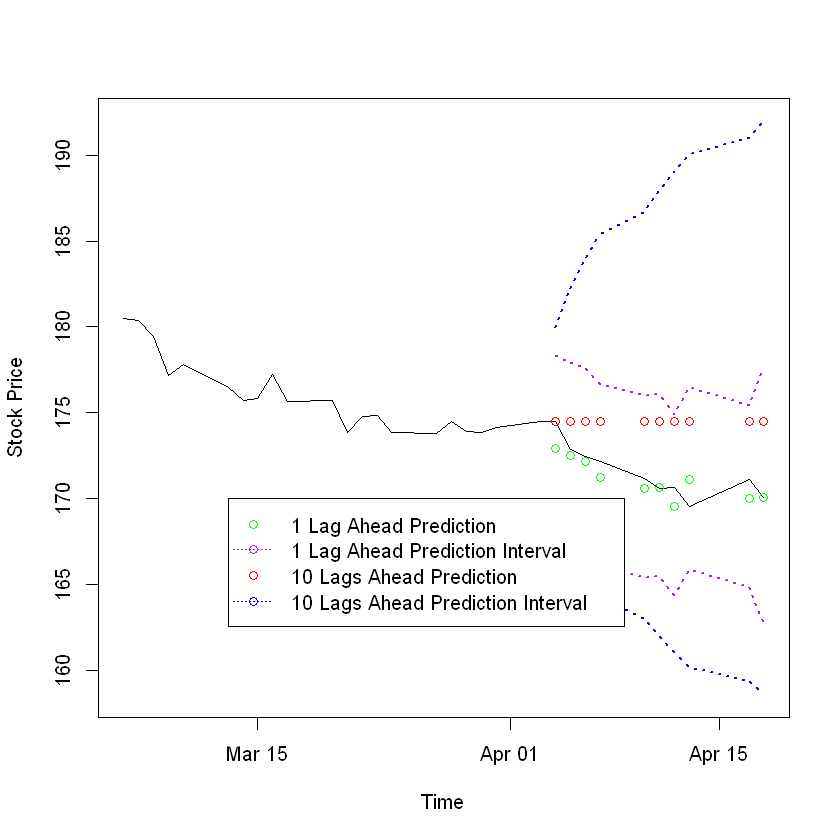

In [13]:
nfit = n-10
ymin = min(exp(c(lbound,lbound.10)))
ymax = max(exp(c(ubound,ubound.10)))
plot(rev(ibm.date)[(n-30):n],exp(ts.price[(n-30):n]),type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Stock Price")
points(rev(ibm.date)[(nfit+1):n],exp(outpred$pred),col="red")
lines(rev(ibm.date)[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines(rev(ibm.date)[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")
points(rev(ibm.date)[(nfit+1):n],exp(outpred.10),col="green")
lines(rev(ibm.date)[(nfit+1):n],exp(ubound.10),lty=3,lwd= 2, col="purple")
lines(rev(ibm.date)[(nfit+1):n],exp(lbound.10),lty=3,lwd= 2, col="purple")
legend(rev(ibm.date)[n-25],170,legend=c("1 Lag Ahead Prediction", "1 Lag Ahead Prediction Interval",
"10 Lags Ahead Prediction","10 Lags Ahead Prediction Interval" ),col=c("green","purple","red","blue"),pch=1,lty = c(0,3,0,3))

Expected narrower confidence interval when rolling over.

In [17]:
## Compute Accuracy Measures for 1 day ahead.
predprice.10 = exp(outpred.10)
### Mean Squared Prediction Error (MSPE)
mean((predprice.10-obsprice)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(predprice.10-obsprice))
### Mean Absolute Percentage Error (MAPE)
mean(abs(predprice.10-obsprice)/obsprice)
### Precision Measure (PM)
sum((predprice.10-obsprice)^2)/sum((obsprice-mean(obsprice))^2)

[1] 0.8909682

[1] 0.7667641

[1] 0.004466037

[1] 0.4428029

In [18]:
### Does the observed data fall outside the prediction intervals?
sum(obsprice<exp(lbound.10))+sum(obsprice>exp(ubound.10))

[1] 0